<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

### <center> Автор материала: Анастасия Малюгина (@malugina)

## <center> Индивидуальный проект по анализу данных 
### <center> Анализ новостей для предсказания фондового рынка

In [1]:
import pandas as pd
import numpy as np
import re
 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, StratifiedKFold, cross_val_score, learning_curve
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import SVC

%matplotlib inline
from matplotlib import pyplot as plt
import pylab 
from pylab import rcParams
import seaborn as sns

from tqdm import tqdm_notebook

from scipy import stats as stats
from scipy.stats.stats import pearsonr 

RANDOM_STATE = 100

## 1. Описание набора данных и признаков

В данном наборе данных предлагается рассмотреть связь между текстами ежедневных новостей и изменением индекса [Доу Джонса](https://ru.wikipedia.org/wiki/Промышленный_индекс_Доу_—_Джонса) (DJIA). Этот индекс отражает состояние американской экономики, и умение его предсказыть позволяет компаниям принимать правильные решения о покупке или продаже акций и ценных бумаг. Индекс расситывается как средняя цена акций 30 крупнейших американских компаний. Определенные новости об этих компаниях способны изменить стоимость их ценных бумаг, и, как следствие, изменить индекс. В данной работе предстоит проверить, насколько тексты новостей влияют на изменение этого индекса.

Данные взяты с [Kaggle](https://www.kaggle.com/aaron7sun/stocknews/data) 

Давайте посмотрим на исходный набор файлов: 

### 1) RedditNews.csv - Список новостей по датам
- Date - дата выхода новости, 
- News - текст новости
- Одна дата - несколько новостей

In [2]:
news = pd.read_csv('RedditNews.csv')
news.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


### 2) DJIA_table.csv - Индекс Доу Джонса по дням

- Date - дата
- Open - значение индекса DJIA на момент открытия торгов
- Close - значение индекса DJIA на момент закрытия торгов
- High, Low - наибольшее и наименьшее значение индекса DJIA в течение указаного дня
- Volume - объём торгов в течение дня
- Adj Close - скорректированное значение индекса DJIA, в который были внесены изменения, включая любые распределения и корпоративные действия, которые произошли в любое время до открытия следующего дня. В этом наборе данных значение этого поля во всех строках равно Close, то есть оно не несет никакой новой информации. Сразу удалим его

In [2]:
djia = pd.read_csv('DJIA_table.csv')
djia.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [4]:
djia[djia['Adj Close'] - djia['Close'] !=0 ].shape

(0, 7)

In [5]:
del djia['Adj Close']

### 3) Combined_News_DJIA.csv 

Это аналог первой таблицы, уже сгруппированный по датам со следующими полями:
- Date - дата
- Label - метка соответствующая положиельному закрытию торгов (1 - положительное, 0 - отрицательное)
- Top1 - Top25 - тексты новостей за указанную дату

In [3]:
news_comb = pd.read_csv('Combined_News_DJIA.csv')
news_comb.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

Метка в таблице Combined_News_DJIA.csv предполагает решение задачи классификации, в плюсе или минусе закроются торги. Но, на мой взгляд, было бы интереснее и логичнее решить задачу регрессии и оценить то, насколько велик будет плюс или минус, так как для принятия решения о финансовых операциях важно знать, поднимется ли этот индекс на половину пункта или на сотни.

Поэтому соединим таблицы news_comb и djia, и подсчитаем разницу в закрытии и открытии. В дальнейшем попробуем рассмотреть абсолютную и относительную разницу в качестве целевой переменной. Рассматривать само значение индекса Доу Джонса в качестве целевой переменной не стоит, так как новости влияют на его изменение относительно начала торгов. 

In [4]:
data = pd.merge(djia, news_comb, on='Date')
data['Diff_abs'] = data['Close'] - data['Open']
data['Diff_rel'] = (data['Close'] - data['Open']) / data['Open']

## 2. Первичный анализ данных

In [8]:
data.describe()

,Open,High,Low,Close,Volume,Label,Diff_abs,Diff_rel
count,1989.000000,1989.000000,1989.000000,1989.000000,1.989000e+03,1989.000000,1989.000000,1989.000000
mean,13459.116048,13541.303173,13372.931728,13463.032255,1.628110e+08,0.535445,3.916206,0.000366
std,3143.281634,3136.271725,3150.420934,3144.006996,9.392343e+07,0.498867,141.227938,0.012525
min,6547.009766,6709.609863,6469.950195,6547.049805,8.410000e+06,0.000000,-774.169922,-0.077833
25%,10907.339844,11000.980469,10824.759766,10913.379883,1.000000e+08,0.000000,-60.169922,-0.004396
50%,13022.049805,13088.110352,12953.129883,13025.580078,1.351700e+08,1.000000,8.540039,0.000642
75%,16477.699219,16550.070312,16392.769531,16478.410156,1.926000e+08,1.000000,74.558594,0.005695
max,18315.060547,18351.359375,18272.560547,18312.390625,6.749200e+08,1.000000,925.190430,0.109329


Проверим заполненность полей:

In [9]:
data.isnull().sum()[data.isnull().sum()>0]

Top23    1
Top24    3
Top25    3
dtype: int64

Видим, что в трёх днях было меньше новостей, чем обычно. Можно было бы исключить эти записи, но, на мой взгляд, их надо оставить, так как тексты всё равно будем объединять, а также попробуем проверить влияние вчерашних новостей на сегодняшний курс. 

In [5]:
# отсортируем по датам:
data.sort_values(by='Date', axis=0, ascending=True, inplace=True)
# переведем тип столбца
data['Date'] = data['Date'].astype(dtype='datetime64[ns]')

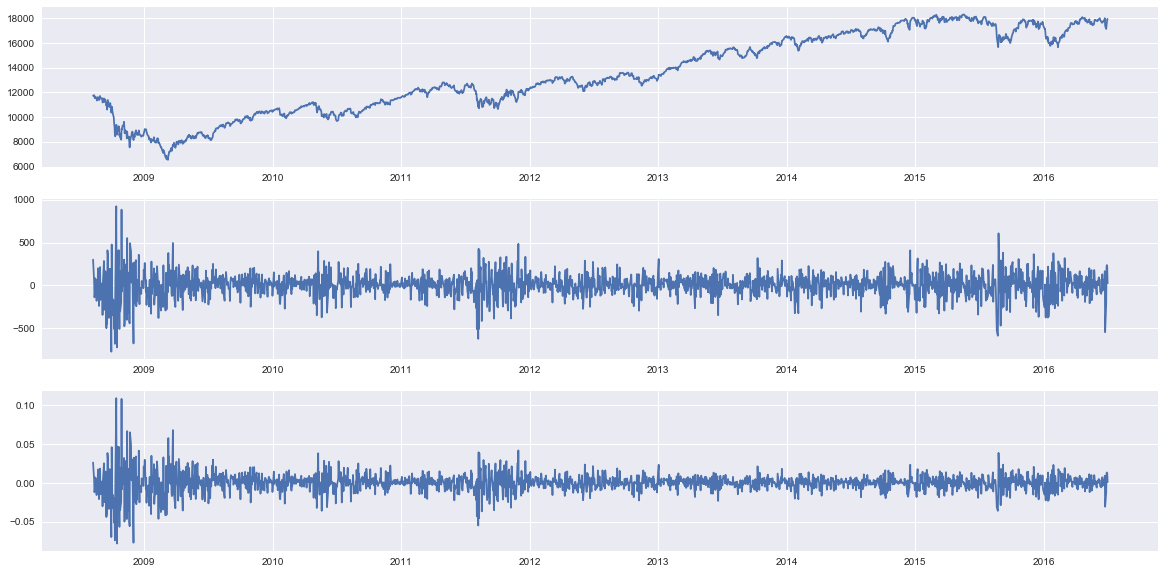

In [11]:
plt.figure(1, figsize=(20, 10))

plt.subplot(311)
plt.plot(data['Date'], data['Close'])

plt.subplot(312)
plt.plot(data['Date'], data['Diff_abs'])

plt.subplot(313)
plt.plot(data['Date'], data['Diff_rel'])

plt.show()

По поводу выбросов сделаю предположение: их нет, данные собраны автоматически, ошибки при ручном вводе исключены, и график (первый) показывает адекватные данные

Посмотрим, не пропущены ли какие либо дни, для этого посчитаем интервалы между текущим и предыдущим днём:

1.0    1558
3.0     359
4.0      52
2.0      18
5.0       1
Name: Date, dtype: int64


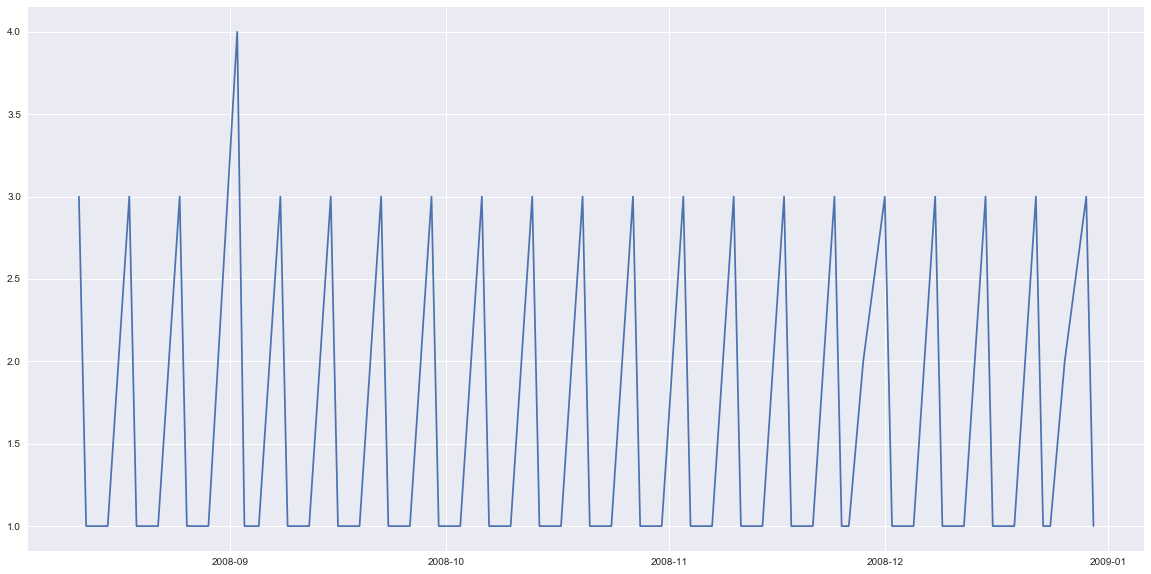

In [12]:
intervals = (data['Date'] - data['Date'].shift(1)).apply(lambda x: x.days)
print(intervals.value_counts())
plt.figure(figsize=(20, 10))
plt.plot(data['Date'][:100], intervals[:100])

Очевидно, что пропуски - это выходные и изредка праздники, то есть дни в которые торги на бирже не проходят. 

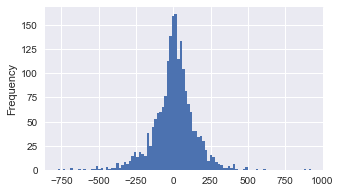

In [13]:
rcParams['figure.figsize'] = 5, 3
data['Diff_abs'].plot(kind='hist', bins=100)

Если смотреть на ранные с точки зрения классификации. то распределение целевой переменной будет следующим:

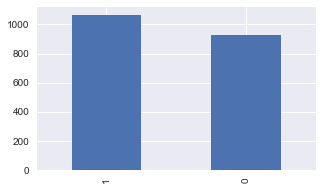

In [14]:
data['Label'].value_counts().plot(kind='bar', label='Рост DJIA')

Присутствует небольшой дисбаланс классов

### Проверка на нормальность

Критерий Шапиро-Уилка:

In [15]:
print(stats.shapiro(data['Close']))
print(stats.shapiro(data['Diff_abs']))
print(stats.shapiro(data['Diff_rel']))

(0.942609965801239, 4.05960070741179e-27)
(0.9482039213180542, 6.586281048971078e-26)
(0.8784092664718628, 7.180058270454129e-37)


Q-Q plot: 

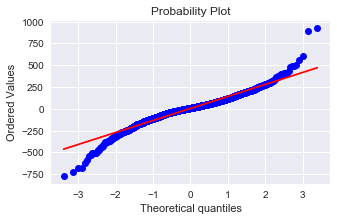

In [16]:
stats.probplot(data['Diff_abs'], dist="norm", plot=pylab)
pylab.show()

### Выводы:

## 3. Первичный визуальный анализ данных

Частично визуальный анализ, касающийся целевой переменной, присутствовал в предыдущем пункте. Так как признаки - это тексты и даты, то применим к ним преобразования

1. Выделим из даты год, год-месяц, месяц, день недели.

In [6]:
data['Year'] = data['Date'].apply(lambda x: x.year)
data['Month'] = data['Date'].apply(lambda x: x.month)
min_year = data['Year'].min()
data['Year_Month'] = data['Date'].apply(lambda x: (x.year - min_year)*12 + x.month)
data['weekday'] = data['Date'].apply(lambda x: x.weekday())

In [18]:
data.head()

,Date,Open,High,Low,Close,Volume,Label,Top1,Top2,Top3,...,Top22,Top23,Top24,Top25,Diff_abs,Diff_rel,Year,Month,Year_Month,weekday
1988,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",302.230468,0.026437,2008,8,8,4
1987,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",52.679687,0.004491,2008,8,8,0
1986,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...",...,b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",-139.230468,-0.011818,2008,8,8,1
1985,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,...,b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,-99.849609,-0.008583,2008,8,8,2
1984,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,...,b'Taliban wages war on humanitarian aid workers',"b'Russia: World ""can forget about"" Georgia\'s...",b'Darfur rebels accuse Sudan of mounting major...,b'Philippines : Peace Advocate say Muslims nee...,83.859376,0.007272,2008,8,8,3


2.1. А теперь соединим все тексты по годам, посчитаем tf-idf и выберем топ-20 слов, наиболее характерных для каждого года.
Для этого соединим все тексты дня в один, а затем сгруппируем по годам:

In [7]:
# очищаем тексты от всего, кроме слов
def filterNews(s):
    if type(s) == str:
        s = s.lower()
        s = re.sub(r'^b[\'\"]','',s)
        s = re.sub(r'[\n]','',s)
        s = re.sub(r'[^a-z ]','',s)
    return s

In [8]:
#Склеенные 25 новостей
data['Combined_news'] = data.filter(regex=('Top.*'))\
    .apply(lambda x: ''.join(x.apply(lambda y: filterNews(y)).values.astype(str)), axis=1) 

In [21]:
#новости, сгруппированные по годам
yearly_news = data.groupby(['Year'])['Combined_news'].apply(lambda x: ''.join(x.values.astype(str)))
yearly_news

Year
2008    georgia downs two russian warplanes as countri...
2009    australia refuses bush administration request ...
2010    new airport scanners break child porn lawsindi...
2011    wikileaks releases cable of the july  meeting ...
2012    shell oil company refuses to clean up its afri...
2013    in pakistan gunmen stop a van containing teach...
2014    japans population falls by record  in kolkata ...
2015    most cases of cancer are the result of sheer b...
2016    saudi arabia breaks off ties with iran  amid r...
Name: Combined_news, dtype: object

In [22]:
# преобразуем текты в мешок слов
# max_df=4 необходимо, чтобы отсеить высокочастотные слова, встречающиеся во многих текстах
# иначе получим максимальный tf-idf у слов типа "the", "of", "to"
# Это связанно с тем, что при расчете idf в библиотеке sklearn используется формула, 
# в которой к логирифму частного прибаляется единица. Таким образом, у слов, которые часто
# встречаются в текстах будет максимальное значение tf-idf

def get_top_words(data, n_top=10, max_df=None):
    cnt = CountVectorizer(max_df=max_df)
    a = cnt.fit_transform(data)
    feature_array = np.array(cnt.get_feature_names())

    tfidf = TfidfTransformer()
    a = tfidf.fit_transform(a)
    #print(pd.DataFrame(a.toarray(),columns=feature_array))

    # посмотрим на n_top самых актуальных слов года
    ar = [] #  и запишем их в этот массив
    for i in range(len(data)):
        tfidf_sorting = np.argsort(a[i].toarray()).flatten()[::-1] # ключи для сортировки
        top_keys = feature_array[tfidf_sorting][:n_top] # сами слова
        top_vals = np.array([a[i].toarray()[0][tfidf_sorting][:n_top]]) # значения их tf-idf
        #print(i,': ',top_n, a[i].toarray()[0][tfidf_sorting][:n_top])
        ar.append(pd.DataFrame(top_vals,columns=top_keys,index=[data.index[i]])) # собираем в один массив

    top_words = pd.concat(ar).fillna(0) # и соединяем все в один датафрейм с общими колонками   
    return top_words

top_words = get_top_words(yearly_news, 10, 4) # посмотрим на 10 самых актуальных слов года
top_words

,abbott,barclays,bnp,bread,brexit,cairos,cceres,corbyn,corrie,crimean,...,tianjin,torpedo,toulouse,tskhinvali,ttip,wilders,xpost,yom,zelaya,zika
2008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.082574,0.000000,0.000000,0.000000,0.049545,0.000000,0.000000
2009,0.000000,0.000000,0.106633,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076873,0.000000
2010,0.000000,0.000000,0.000000,0.048944,0.000000,0.000000,0.000000,0.000000,0.06371,0.000000,...,0.000000,0.056631,0.000000,0.000000,0.000000,0.056631,0.000000,0.000000,0.000000,0.000000
2011,0.000000,0.000000,0.000000,0.000000,0.000000,0.073064,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2012,0.000000,0.053961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.058215,0.000000,0.000000,0.000000,0.070150,0.000000,0.000000,0.000000
2013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072065,0.000000,0.000000,0.000000
2014,0.157849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.066966,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015,0.057466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.055895,0.000000,0.000000,0.000000,0.073885,0.000000,0.000000,0.000000,0.000000,0.000000
2016,0.000000,0.000000,0.000000,0.000000,0.098187,0.000000,0.073977,0.071409,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.100893,0.000000,0.000000,0.000000,0.000000,0.338183


Наконец, можно приступить к визуализации! 

### 1. По годам.
Построим тепловую карту самих коэффициентов и корреляции слов.

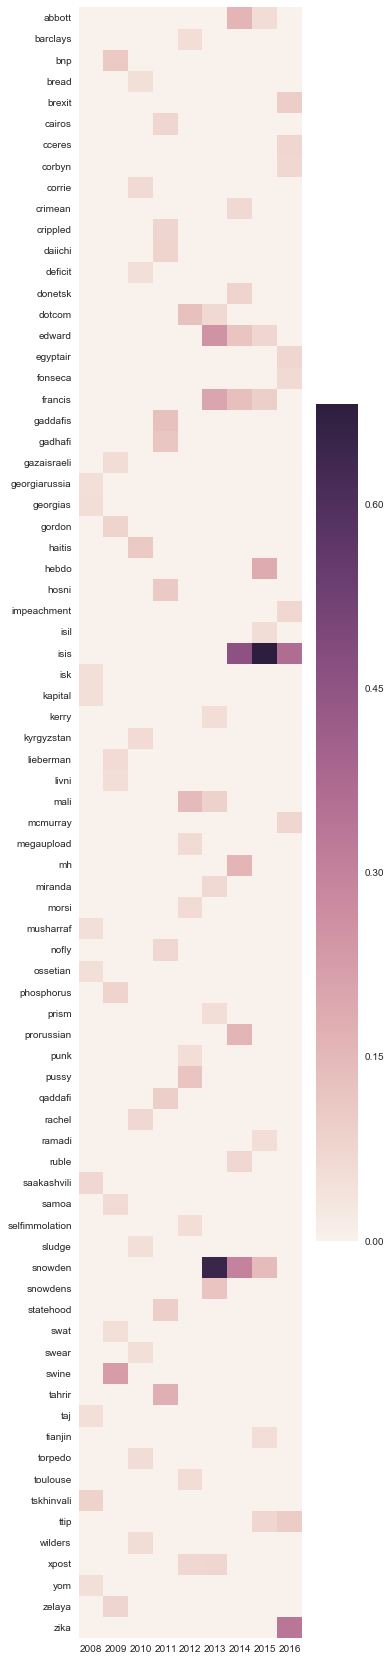

In [23]:
rcParams['figure.figsize'] = 5, 30
sns.heatmap(top_words.T, annot=False)

На этом графике очень наглядно видны тенденции: про Сноудена активно говорили в 2013 году, потом в 2014 меньше (но тоже часто упоминали), в 2015 еще реже, а в 2016 уже и не попало его имя в топ-10 слов. Одновременно идет чуть более слабая тенденция для слова Edward (это же имя Сноудена, и оно также упоминалось в новостях в 2014 и потом пошло на спад). Другое заметное пятно - это упоминание isis (исламское государство) в 2014-2016 годах. Если увеличить картинку, и вчитаться, то можно увидеть много знакомых новостей: Донецк обсуждали в 2014, Грузию, Грузию-Россию и Саакашвили в 2008. Вот тут возникает мысль построить матрицу коррелиции и посмотреть, какие новости обсуждали одновременно:

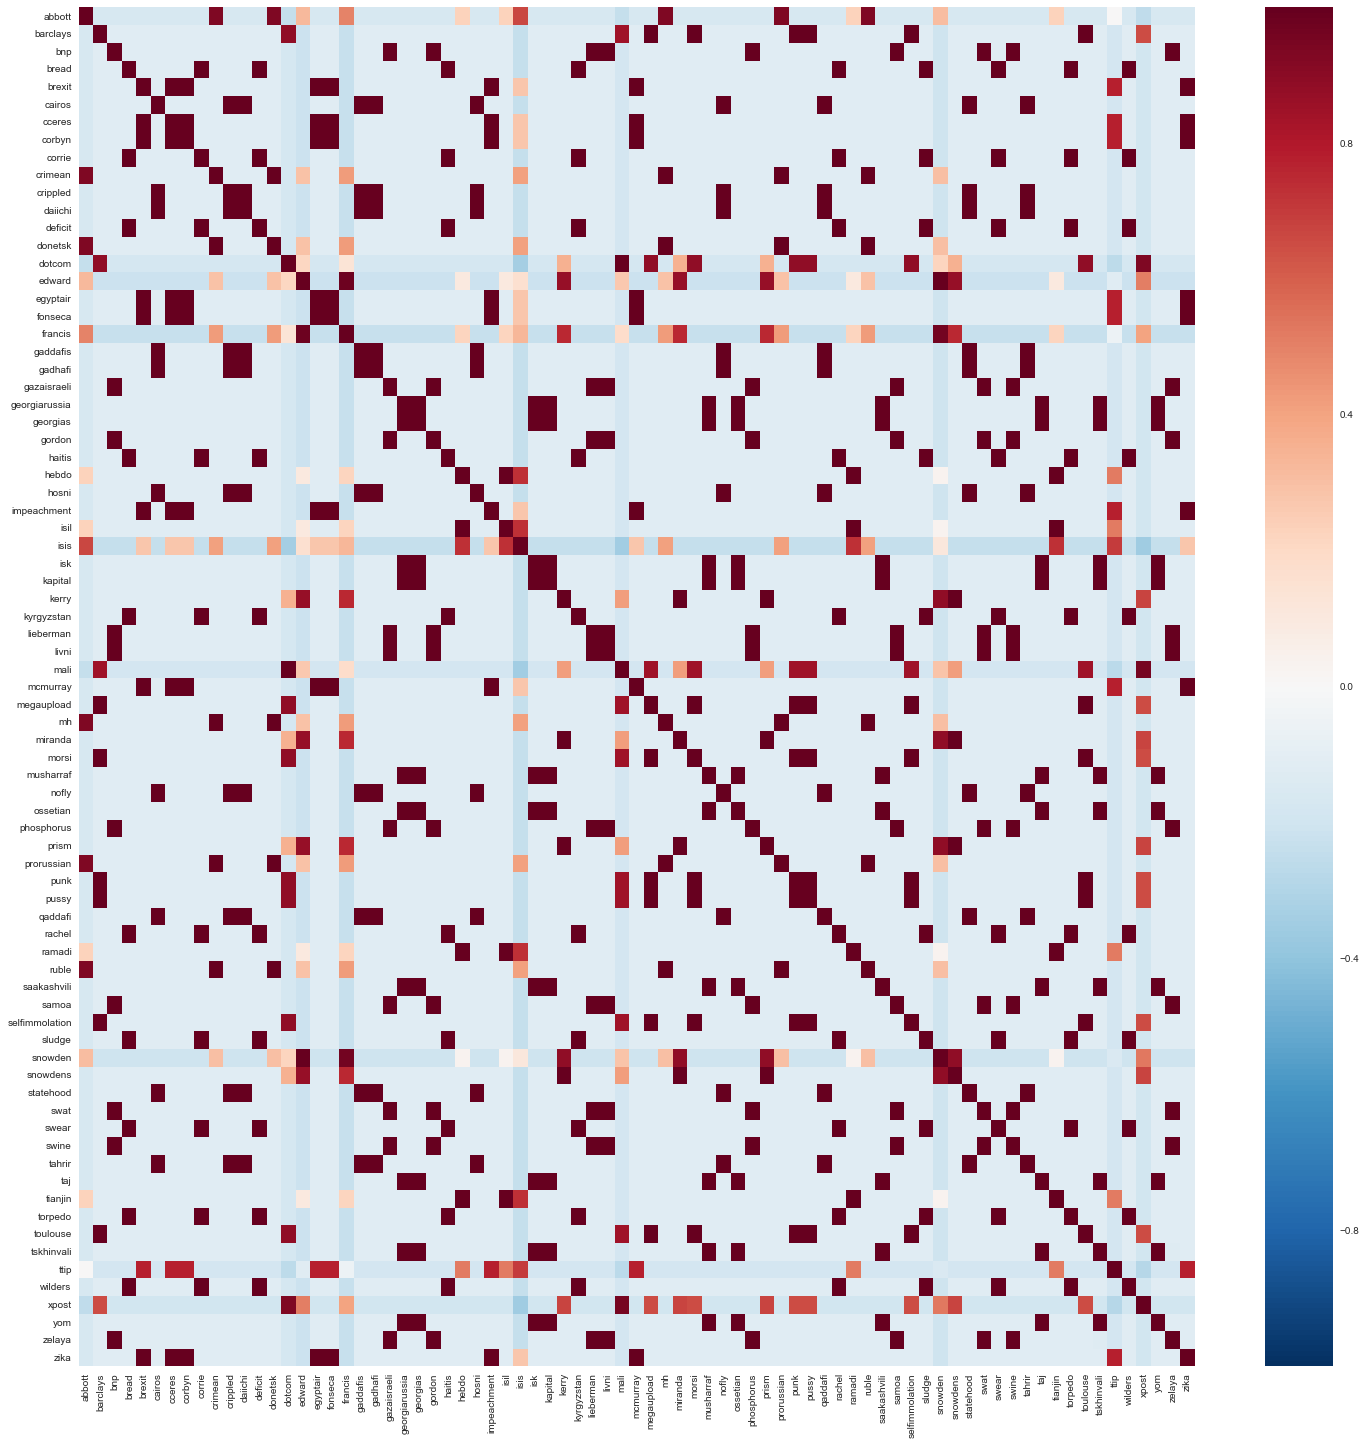

In [24]:
rcParams['figure.figsize'] = 25, 25
sns.heatmap(top_words.corr(), annot=False)

Но эта матрица кажется мне не слишком выразительной, многие слова, активно упоминаемые в один год, нельзя назвать взаимосвязанными. Год - достаточно большой период. поэтому тут много сильно скоррелированных слов. Попробуем построить по месяцам и дням.

In [25]:
monthly_news = data.groupby(['Year_Month'])['Combined_news'].apply(lambda x: ''.join(x.values.astype(str)))

top_words = get_top_words(monthly_news, 3, max_df=0.9) # посмотрим на 1 самых актуальных слов месяца
top_words.head()

,abortion,abuse,acid,acta,afghanistan,ahmadinejad,almabhouh,almegrahi,antiislam,apocalypse,...,ukrainian,venezuela,volcano,weiwei,wikileaks,wikipedia,wildfires,xinjiang,yom,zika
8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.133351,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
10,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.075229,0.0
11,0.0,0.0,0.125085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
12,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


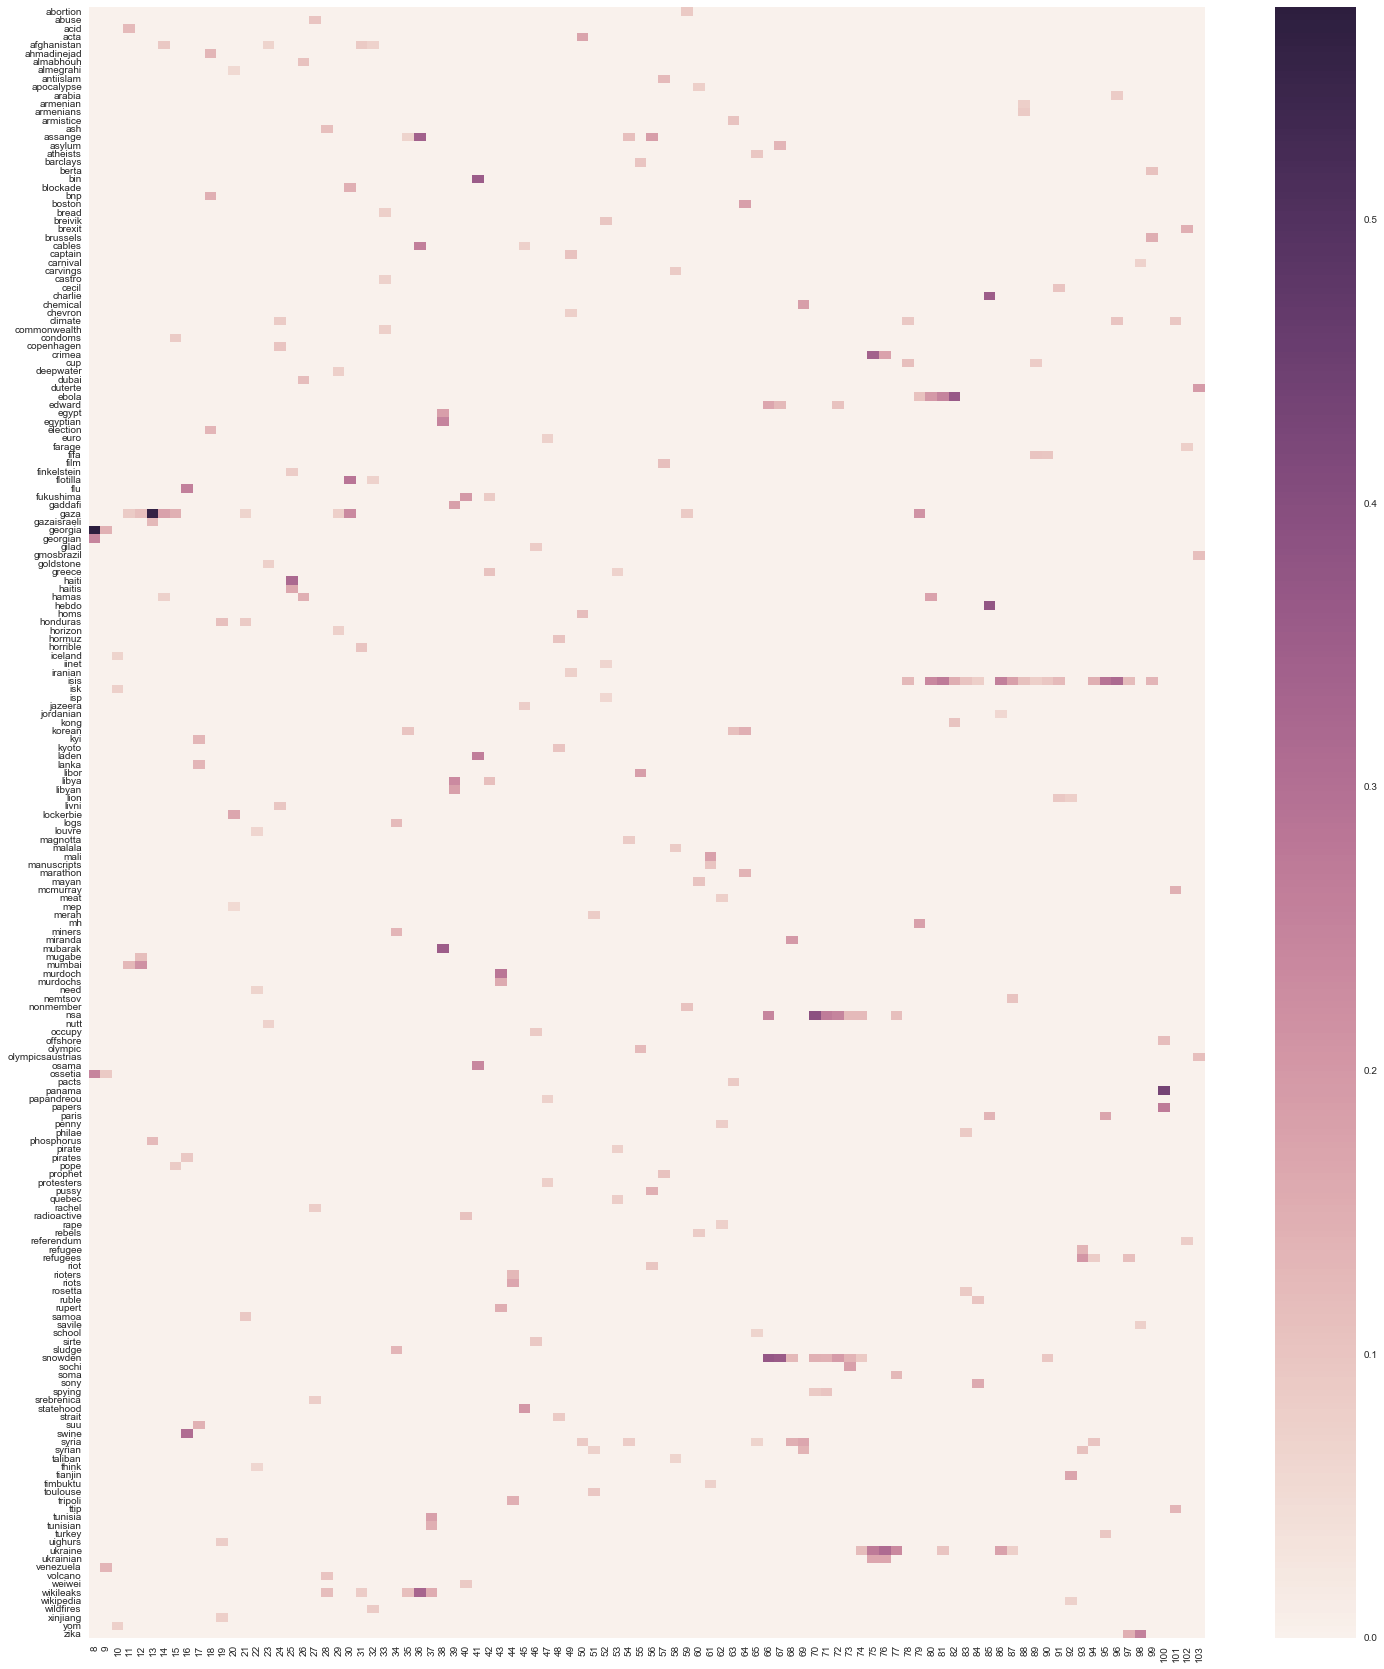

In [26]:
rcParams['figure.figsize'] = 25, 30
sns.heatmap(top_words.T, annot=False)

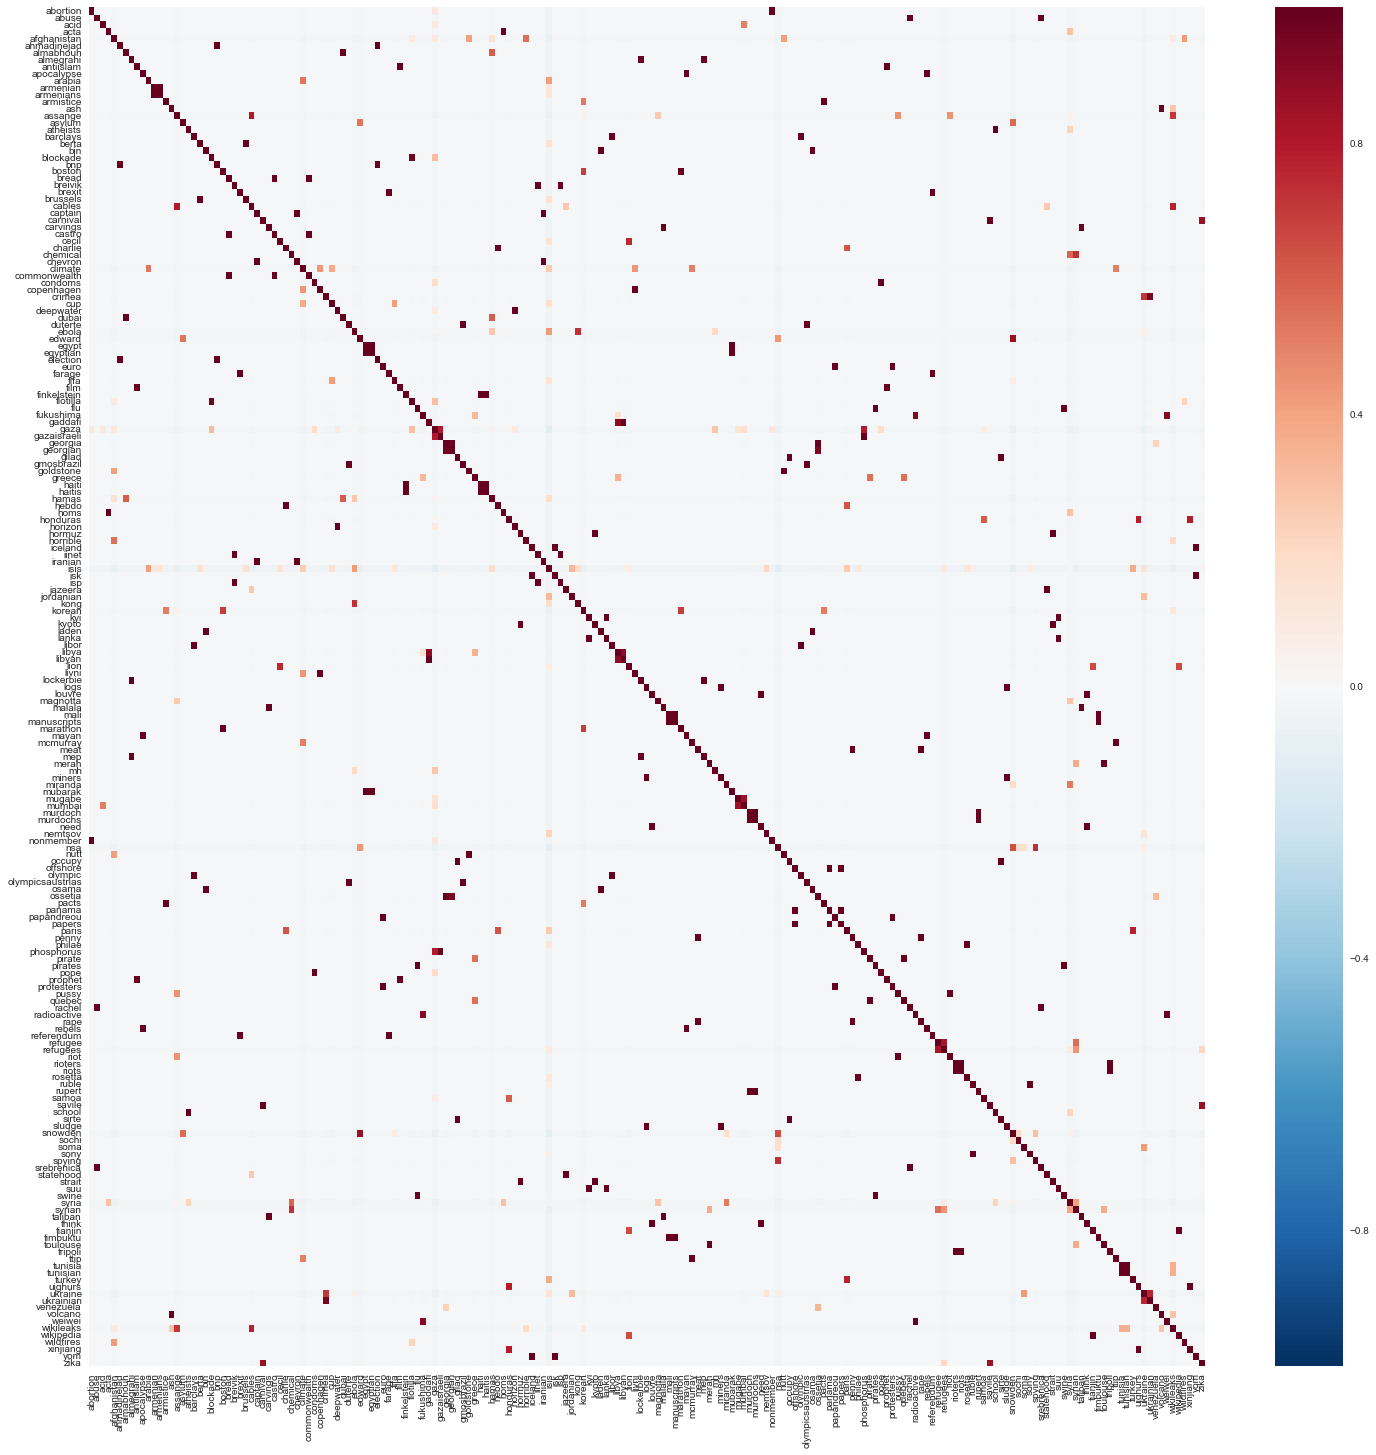

In [27]:
rcParams['figure.figsize'] = 25, 25
sns.heatmap(top_words.corr(), annot=False)

Посмотрим, что предаставлюят из себя пары сильно скоррелированных слов:

In [28]:
corr = top_words.corr()
corr = corr - np.tril(corr)
corr.stack().nlargest(20)

kyoto       strait       1.0
deepwater   horizon      1.0
copenhagen  livni        1.0
miners      sludge       1.0
kyi         suu          1.0
gaddafi     libyan       1.0
laden       osama        1.0
murdochs    rupert       1.0
armistice   pacts        1.0
louvre      think        1.0
pirates     swine        1.0
logs        miners       1.0
abortion    nonmember    1.0
breivik     isp          1.0
riots       tripoli      1.0
almabhouh   dubai        1.0
merah       toulouse     1.0
apocalypse  mayan        1.0
penny       rape         1.0
pussy       riot         1.0
dtype: float64

Мы получили пары слов, упоминаемых одновременно: про апокалипсис говорили тогда же, когда и про Майя, Кадаффи - Ливия и т.д.

### По дням:

Строить графики нет смысла, т.к. визуально их не оценить. Тут можно перейти к связи слов и индекса ДоуДжонса: какие слова в новостях совпали с повышением и с понижением этого индекса? 

In [9]:
cnt = CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=3) #min_df=3 - чтобы исключить слова с ошибками
words = cnt.fit_transform(data['Combined_news'])
feature_array = np.array(cnt.get_feature_names())

tfidf = TfidfTransformer()
words_tfidf = tfidf.fit_transform(words)


In [31]:
corr = np.empty(words_tfidf.shape[1])
targ = np.array([data['Diff_abs']]).T
for i in tqdm_notebook(range(words_tfidf.shape[1])):#a1.shape[1]-1
    corr[i] = pearsonr(words_tfidf[:,i].toarray(), targ)[0][0]

In [32]:
corr = pd.Series(corr, index=feature_array)
corr.nlargest(15)

dead pakistan     0.122533
syria says        0.116308
dead thousands    0.114888
autonomy          0.114390
incandescent      0.114356
paul              0.108518
textbook          0.104855
jamaican          0.103730
excrement         0.102769
settling          0.102371
light bulbs       0.101223
damn              0.101055
pub               0.099936
chefs             0.099178
jams              0.098289
dtype: float64

Обрантая корреляция (частое упротребление каких слов приводит к понижению индекса) :

In [33]:
(-corr).nlargest(15)

saakashvili                 0.115892
month low                   0.114031
wideranging                 0.112157
accused witchcraft          0.108462
video israeli               0.106786
regulate internet           0.106129
commercialize               0.105335
film crew                   0.105245
shoots dead                 0.102816
neocons                     0.102194
rothschild                  0.099941
rocketpropelled             0.098777
rocketpropelled grenades    0.098777
embassy yemen               0.098286
develop nuclear             0.097595
dtype: float64

Корелляция частоты слов и изменений биржевого индекса слабая, менее 0.12. Значит, каждое отдельно взятое слово (или пара слов) не влияет существено на целевую переменную.

Построим простую линейную модель и посмотрим на слова с самыми высокими по модую коэффициентами:

In [34]:
# функция взята из лекции по линейным моделям
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [35]:
from sklearn.svm import SVC

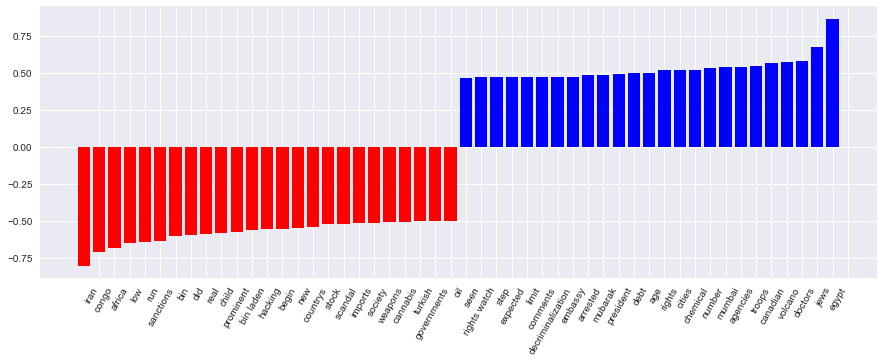

In [36]:
model =  LogisticRegression()
model.fit(words_tfidf, data['Label'])
visualize_coefficients(model, feature_array, 25)

Так как модель линейная, то "синие" слова связаны с повышением биржевого индекса, а "красные" - с понижением. Посмотрим, насколько можно умньшить размерность, сохранив 90% дисперсии:

In [ ]:
pca = PCA().fit(words_tfidf.toarray())


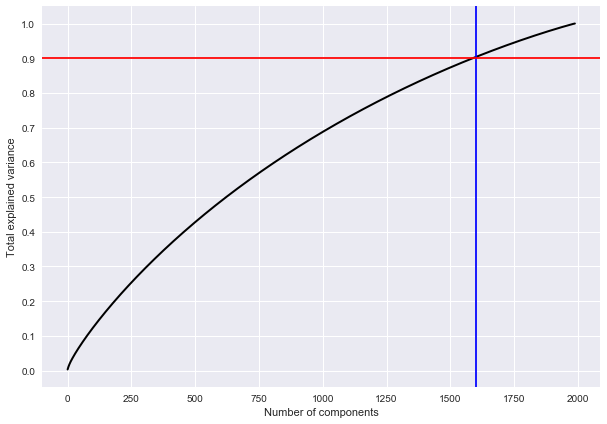

In [12]:

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
#plt.xlim(0, 1263)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(1600, c='b')
plt.axhline(0.9, c='r')
plt.show();

# 5. Выбор метрики

Так как классы несколько несбалансированы, а также для оценки полезности модели будем использовать ROC-AUC 

# 6. Выбор модели

Так как обрабатывать будем разреженные данные, то для этого отлично подходят линейные модели. Для работы с текстом часто используют метод опорных векторов. Также сделаем предположение, что в дни с похожили новостями будут и похожие изменения, поэтому попробуем метод ближайших соседей. И градиентный бустинг, ну как его не проверить) Проверим все методы, сравним их эффективность.

# 7. Предобработка данных

##### 7.1. Разобъём данные на обучающую и тестовую выборки:

Как уже делалось ранее, склеим тексты новостей в одно поле, оставив лишь слова. В раздельном хранении нет смысла, так как новости (поля Top1-Top25) не упорядочены по значимости, категории или как то ещё. И отдельное преобразование не даст результата, так как в одном признаке будут разные ничем не связанные тексты.

In [42]:
data['Combined_news'] = data.filter(regex=('Top.*'))\
    .apply(lambda x: ''.join(x.apply(lambda y: filterNews(y)).values.astype(str)), axis=1) 

Наиболее логичным разбиением для этой задачи будет разбиение по дате: до - обучающая, после - тестовая. Перемешивание может привести к утечке данных, в итоге получив завышенный результат.
Треть данных оставим для тестовой выборки

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Label'],axis=1), data['Label'], test_size=0.33)

"Мешок слов" следует обучать только на тренировочной выборке, применив преобразование к тестовой, чтобы не заглядывать вперед. 
И также с TF_IDF. 

In [335]:
count_vect = CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=3)
count_vect.fit(X_train['Combined_news'])
X_train_text = count_vect.transform(X_train['Combined_news'])
X_test_text = count_vect.transform(X_test['Combined_news'])

tfidf = TfidfTransformer()
tfidf.fit(X_train_text)
X_train_text = tfidf.transform(X_train_text)
X_test_text = tfidf.transform(X_test_text)


В дальнейшем будем использовать подобное последовательное преобразование: 

In [44]:
pipe_cnt_tfidf = Pipeline([
    ('count', CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('scaler', MaxAbsScaler()),
    ('classifier',LogisticRegression())
])

Стоит заметить, что данный датасет можно рассмативать и как временной ряд, прогнозируя значения последовательно, опираясь на предыдущие. Но основная задачу тут - рассмотреть свять между текстами новостей и их влиянием на индекс ДоуДжонса.

# 8. Кросс-валидация и настройка гиперпараметров модели

Создадим Pipeline, чтобы отдельно преобразовывать в tfidf блоки, предназначенные для обучения и для валидации. Для масштаброввания использую MaxAbsScaler, который специально разработан для преобразования разреженных матриц.
Я не удержалась и к логистической регрессии добавила метод опорных векторов и градиентный бустинг (ну как без него), чтобы сравнить результаты. Число фолдов равно 3, это почти минимум, чтобы оценить среднеквадратичное отклонение, а при большем числе фолдов на некоторых алгоритмах ноут перегревается и отключается ¯\\_(ツ)_/¯

In [48]:
pipe_cnt_tfidf = Pipeline([
    ('count', CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('scaler', MaxAbsScaler()),
    ('classifier',LogisticRegression())
])
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=99)
param_grid = [
    {
        'classifier': [LogisticRegression()],
        'classifier__C': np.logspace(-6,2,12)
    },
    {
        'classifier': [LogisticRegression(solver='newton-cg')],
        'classifier__max_iter': [5,10,50,100]
    },
    {
        'classifier': [LinearSVC()],
        'classifier__C': np.logspace(-6,2,8)
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,7,15,30]
    }

]

grid = GridSearchCV(pipe_cnt_tfidf, cv=kf, n_jobs=1, param_grid=param_grid, scoring='roc_auc')
grid.fit(X_train['Combined_news'], y_train)
grid.best_score_

0.5085548237110592

На тренировочной части оценка близка к 1, а на валидационной - 0.5. Это говорит о переобучении модели, даже при очень малых значениях С (см. далее кривые валидации)

In [13]:
# преобразование разреженной матрицы в массив, чтобы его можно было встроить в pipeline
class ToArrayTransformer(BaseEstimator, TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [18]:
pipe_cnt_tfidf_gb = Pipeline([
    ('count', CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('toarray', ToArrayTransformer()),
    #('PCA',PCA(n_components=1000)),
    ('classifier',GradientBoostingClassifier(max_features='log2', subsample=0.9, random_state=99))
])
param_grid = [
    {
        'classifier__n_estimators': [10,100,500,1000]
    },
]

grid = GridSearchCV(pipe_cnt_tfidf_gb, cv=kf, n_jobs=1, param_grid=param_grid, scoring='roc_auc')
grid.fit(X_train['Combined_news'], y_train)
grid.best_score_

0.54128331067007829

In [21]:
grid.cv_results_['mean_test_score']

array([ 0.50657958,  0.5125877 ,  0.52840891,  0.54128331])

In [25]:
grid.cv_results_

{'mean_fit_time': array([ 4.8235987 ,  5.17362436,  6.72038436,  9.34953507]),
 'mean_score_time': array([ 0.82338079,  0.81571301,  0.86104957,  1.02305873]),
 'mean_test_score': array([ 0.50657958,  0.5125877 ,  0.52840891,  0.54128331]),
 'mean_train_score': array([ 0.67947468,  0.98693754,  1.        ,  1.        ]),
 'param_classifier__n_estimators': masked_array(data = [10 100 500 1000],
              mask = [False False False False],
        fill_value = ?),
 'params': ({'classifier__n_estimators': 10},
  {'classifier__n_estimators': 100},
  {'classifier__n_estimators': 500},
  {'classifier__n_estimators': 1000}),
 'rank_test_score': array([4, 3, 2, 1]),
 'split0_test_score': array([ 0.48993761,  0.53413262,  0.53001387,  0.53631433]),
 'split0_train_score': array([ 0.67448406,  0.98637409,  1.        ,  1.        ]),
 'split1_test_score': array([ 0.51719796,  0.52554102,  0.53293205,  0.54239093]),
 'split1_train_score': array([ 0.68375519,  0.98609226,  1.        ,  1.        

И построим сразу для бустринг кривую валидации, чтобы не запускать все заново:

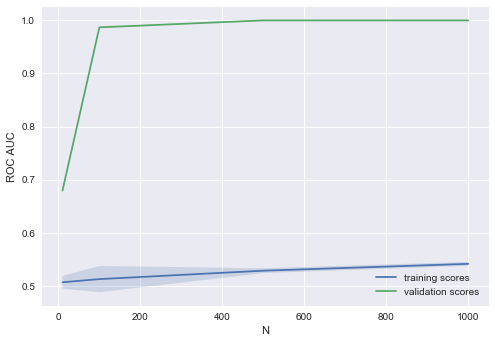

In [30]:
test_res = np.array([grid.cv_results_['split0_test_score'],grid.cv_results_['split1_test_score'],grid.cv_results_['split2_test_score']]).T;
train_res = np.array([grid.cv_results_['split0_train_score'],grid.cv_results_['split1_train_score'],grid.cv_results_['split2_train_score']]).T;
plot_with_err([10,100,500,1000], test_res, label='training scores')
plot_with_err([10,100,500,1000], train_res, label='validation scores')
plt.xlabel('N'); plt.ylabel('ROC AUC')
#plt.xscale('log')
plt.legend()

Как видно, результаты неудовлетворительные, сравнимые с константным классификатором, т.к. roc_auc колеблется около 0.5 (+/- 0.03) Хотя на графике бустинга заметна небольшая тенденция по улучшению качества при увеличении числа деревьев.

# 9. Создание новых признаков и описание этого процесса

#### 9.1. Текст вчерашней новости (Tfidf)
В описании данных нет информации о точном времени выхода новости, и можно предположить, что новости, опубликованные вчера после закрытия торгов на бирже, повлияют на курс только сегодня. Также можно предположить, что эффект от новости будет распространяться и на следующий день

In [62]:
data['Combined_news_prev'] = data['Combined_news'].shift(1)

In [67]:
pipe_cnt_tfidf = Pipeline([
    ('count', CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('scaler', MaxAbsScaler()),
    ('classifier',LogisticRegression())
])
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=99)
param_grid = [
    {
        'classifier': [LogisticRegression()],
        'classifier__C': np.logspace(-6,2,12)
    }]

grid = GridSearchCV(pipe_cnt_tfidf, cv=kf, n_jobs=1, param_grid=param_grid, scoring='roc_auc')
grid.fit(data['Combined_news_prev'][1:], data['Label'][1:])
grid.best_score_

0.51055116848535542

#### 9.2. Месяц, год, день недели
Месяц, год, день недели уже были подготовлены в пункте 3 (при первичном визуальном анализе)

In [43]:
data['DayOfMonth'] = data['Date'].apply(lambda x: x.day)
data['WeekOfYear'] = data['Date'].apply(lambda x: x.weekofyear)

In [45]:
data_dates = data[['Date','Year','Month','weekday','Year_Month','DayOfMonth','WeekOfYear']]
data_dates.head()

,Date,Year,Month,weekday,Year_Month,DayOfMonth,WeekOfYear
1988,2008-08-08,2008,8,4,8,8,32
1987,2008-08-11,2008,8,0,8,11,33
1986,2008-08-12,2008,8,1,8,12,33
1985,2008-08-13,2008,8,2,8,13,33
1984,2008-08-14,2008,8,3,8,14,33


In [49]:
data_dates = pd.get_dummies(data=data_dates, columns=['Date','Year','Month','weekday','Year_Month','DayOfMonth','WeekOfYear'])
data_dates.shape

(1989, 2195)

In [58]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=99)
gb = GradientBoostingClassifier(max_features='log2', subsample=0.9, random_state=99)
grid = GridSearchCV(gb, cv=kf, param_grid={'n_estimators':[100,500,1000]}, scoring='roc_auc')
grid.fit(data_dates, data['Label'])
grid.best_score_

0.50562313273580883

In [60]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=99)
lr = LogisticRegression()
grid = GridSearchCV(lr, cv=kf, param_grid={'C':np.logspace(-6,2,10)}, scoring='roc_auc')
grid.fit(data_dates, data['Label'])
grid.best_score_

0.51475519785378931

Результаты тоже плохи. Смысла добавлять эти признаки нет. Вероятно, может улучшить ситуацию смысловая обработка текстов, разделение новостей на категории и отбор и использование только тех новостей, которые действительно как-то влияют на биржевой индекс. А также выделение сущностей: объекты, действия. Но это тоько перспектива и не входит в данную работу, 

# 10. Построение кривых валидации и обучения

In [23]:
def plot_with_err(x, data, **kwargs): # функция взята из лекции на Хабре
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
    facecolor=lines[0].get_color(), alpha=0.2)

Кривая валидации для логистической регрессии: 

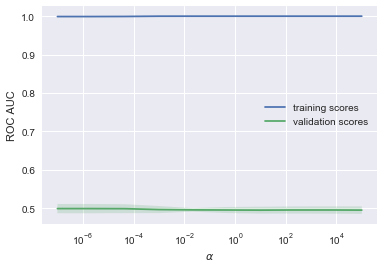

In [418]:
pipe_cnt_tfidf_lr = Pipeline([
    ('count', CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('scaler', MaxAbsScaler()),
    ('classifier',LogisticRegression())
])
C_range = np.logspace(-7,5,10)
val_train, val_test = validation_curve(estimator=pipe_cnt_tfidf, 
                                       X=X_train['Combined_news'], 
                                       y=y_train, 
                                       param_name='classifier__C', 
                                       param_range=C_range, 
                                       cv=3, 
                                       scoring='roc_auc')


plot_with_err(C_range, val_train, label='training scores')
plot_with_err(C_range, val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('ROC AUC')
plt.xscale('log')
plt.legend()

Для метода опорных векторов: 

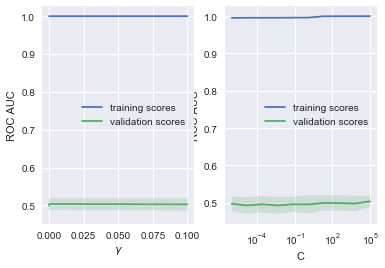

In [24]:
pipe_cnt_tfidf = Pipeline([
    ('count', CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC())
])
С_range = np.logspace(-6, 5, 10)
val_train, val_test = validation_curve(estimator=pipe_cnt_tfidf, 
                                       X=X_train['Combined_news'], 
                                       y=y_train, 
                                       param_name='classifier__C', 
                                       param_range=С_range, 
                                       cv=3, 
                                       scoring='roc_auc')
plt.subplot(122)
plot_with_err(С_range, val_train, label='training scores')
plot_with_err(С_range, val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('ROC AUC')
plt.xscale('log')
plt.legend()

gamma_range = np.logspace(-6, -1, 5)
val_train, val_test = validation_curve(estimator=pipe_cnt_tfidf, 
                                       X=X_train['Combined_news'], 
                                       y=y_train, 
                                       param_name='classifier__gamma', 
                                       param_range=gamma_range, 
                                       cv=3, 
                                       scoring='roc_auc')


plt.subplot(121)
plot_with_err(gamma_range, val_train, label='training scores')
plot_with_err(gamma_range, val_test, label='validation scores')
plt.xlabel(r'$\gamma$'); plt.ylabel('ROC AUC')
plt.legend()



Для градиентного бустинга - выполнена выше.

### Кривая обучения:

In [ ]:
pipe_cnt_tfidf_lr = Pipeline([
    ('count', CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('scaler', MaxAbsScaler()),
    ('classifier',LogisticRegression())
])

train_sizes, train_scores, valid_scores = learning_curve(estimator=pipe_cnt_tfidf_lr, 
                                                         X=X_train['Combined_news'], 
                                                         y=y_train, 
                                                         cv=3, 
                                                         scoring='roc_auc', 
                                                         train_sizes=np.linspace(0.1, 1.0, 5))


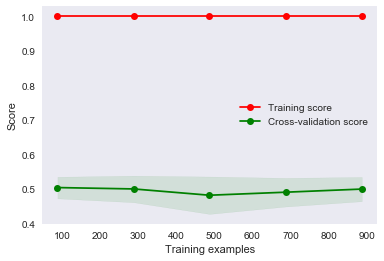

In [60]:
plt.figure()

plt.xlabel("Training examples")
plt.ylabel("Score")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()


Результаты одинаково плохи, как при малом числе примеров, так и при большом. 

# 11. Прогноз для тестовой или отложенной выборки

In [38]:
pipe_cnt_tfidf_lr = Pipeline([
    ('count', CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=2)),
    ('tfidf', TfidfTransformer()),
    ('scaler', MaxAbsScaler()),
    ('classifier',LogisticRegression())
])

pipe_cnt_tfidf_lr.fit(X_train['Combined_news'], y_train)
pred = pipe_cnt_tfidf_lr.predict_proba(X_test['Combined_news'])
roc_auc_score(y_test, pred[:,1])

0.47688884768703066

In [40]:
pipe_cnt_tfidf_gb = Pipeline([
    ('count', CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('toarray', ToArrayTransformer()),
    ('classifier',GradientBoostingClassifier(n_estimators=1200, max_features='log2', subsample=0.9, random_state=99))
])

pipe_cnt_tfidf_gb.fit(X_train['Combined_news'], y_train)
pred = pipe_cnt_tfidf_gb.predict_proba(X_test['Combined_news'])
roc_auc_score(y_test, pred[:,1])

0.48160749049782142

Результаты проверки для отложенной выборки оказались сравнимы с результатами кроссвалидации: roc_auc около 0.5, что говорит о бесполезном классификаторе. Возможно, можно было бы еще поиграть с настройками классификаторов, но факт того, что все классификаторы не вышли за пределы даже 0.55, говорит о том, что связь между признаками и целевой переменной отсутствует.

# 12. Выводы

Полученные модели не дали адекватных прогнозов, ценность решения - нулевая, и, как следствие, отсутствие возможных применений. Это говорит о том, что в таком виде использовать новости для прогноза биржевого индекса нельзя. Возможно, если бы данные имели другой вид, например, было бы указано время публикации новости и приведены поминутные изменения индекса (а лучше - курса акций составляющих компаний). Если же говорить об анализе текста новостей, то стоит провести лексический анализ, например с помощью NLTK. 